In [1]:
import os
import numpy as np
import sys
import random
import torch
from moleculekit.molecule import Molecule
import matplotlib.pyplot as plt
import parmed
import nglview as ng
import MDAnalysis as md

import openmm.app as app
from openmm import Platform, LangevinMiddleIntegrator, XmlSerializer
from openmm.unit import picosecond, kelvin
from openmm import unit
import openmm

import mymd

In [2]:
seed = 142
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_path = '../../data/acc_md_with_ai/aspirin/'
out_path = '../../data/acc_md_with_ai/aspirin/rslt_openmm/'

pdb_file = os.path.join(data_path, 'aspirin.pdb')
psf_file = os.path.join(data_path, 'aspirin.psf')
prmtop_file = os.path.join(data_path, 'aspirin.prmtop')

cutoff = 5
box = np.array([100., 100., 100.])
T = 300 * kelvin
steps = 50000
logInterval = 100
dt = 0.002 * picosecond
friction = 1 / picosecond

In [4]:
mol = mymd.get_molecule(prmtop_file=prmtop_file, pdb_file=pdb_file)

2023-05-15 22:06:52,765 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [5]:
class MyAmberParameterSet(parmed.amber.AmberParameterSet):
    """Inherited from AmberParameterSet to modify from_structure method."""

    @classmethod
    def my_from_structure(cls, struct):
        return super(parmed.amber.AmberParameterSet, cls).from_structure(struct, allow_unequal_duplicates=True)


structure = parmed.load_file(prmtop_file)
topology = structure.topology
try:
    prm = parmed.amber.AmberParameterSet().from_structure(structure)
except:
    print('wrong')
    prm = MyAmberParameterSet.my_from_structure(structure)
print(isinstance(structure, parmed.amber.AmberParm))

a = unit.Quantity((box[0] * unit.angstrom, 0 * unit.angstrom, 0 * unit.angstrom))
b = unit.Quantity((0 * unit.angstrom, box[1] * unit.angstrom, 0 * unit.angstrom))
c = unit.Quantity((0 * unit.angstrom, 0 * unit.angstrom, box[2] * unit.angstrom))
structure.box_vectors = (a, b, c)

system = structure.createSystem(nonbondedMethod=app.CutoffPeriodic,
                                nonbondedCutoff=cutoff * unit.angstrom,
                                switchDistance=0)
system.setDefaultPeriodicBoxVectors(a, b, c)

integrator = LangevinMiddleIntegrator(T, friction, dt)
platform = openmm.Platform.getPlatformByName('OpenCL')
properties = dict()

simulation = app.Simulation(topology, system, integrator, platform, properties)
simulation.context.setPositions(mol.coords * unit.angstrom)
simulation.context.setVelocitiesToTemperature(T, seed)

# save psf file for future visualization
parmed_structure = parmed.openmm.load_topology(topology, system, mol.coords * unit.angstrom)
parmed_structure.save(os.path.join(out_path, 'openmm_aspirin.psf'), overwrite=True)

2023-05-15 22:06:52,976 - parmed.structure - INFO - Adding bonds...
2023-05-15 22:06:52,977 - parmed.structure - INFO - Adding angles...
2023-05-15 22:06:52,978 - parmed.structure - INFO - Adding dihedrals...
2023-05-15 22:06:52,978 - parmed.structure - INFO - Adding Ryckaert-Bellemans torsions...
2023-05-15 22:06:52,978 - parmed.structure - INFO - Adding Urey-Bradleys...
2023-05-15 22:06:52,979 - parmed.structure - INFO - Adding improper torsions...
2023-05-15 22:06:52,979 - parmed.structure - INFO - Adding CMAP torsions...
2023-05-15 22:06:52,979 - parmed.structure - INFO - Adding trigonal angle terms...
2023-05-15 22:06:52,979 - parmed.structure - INFO - Adding out-of-plane bends...
2023-05-15 22:06:52,979 - parmed.structure - INFO - Adding pi-torsions...
2023-05-15 22:06:52,980 - parmed.structure - INFO - Adding stretch-bends...
2023-05-15 22:06:52,980 - parmed.structure - INFO - Adding torsion-torsions...
2023-05-15 22:06:52,980 - parmed.structure - INFO - Adding Nonbonded force..

True


In [6]:
with open(os.path.join(out_path, 'state_before_min.xml'), 'w') as f:
    f.write(
        XmlSerializer.serialize(
            simulation.context.getState(getPositions=True,
                                        getVelocities=True,
                                        getForces=True,
                                        getEnergy=True,
                                        getParameters=True,
                                        getParameterDerivatives=True,
                                        getIntegratorParameters=True,
                                        enforcePeriodicBox=True)))

In [7]:
# Minimize
print("\nInitial system energy")
print(simulation.context.getState(getEnergy=True).getPotentialEnergy())
print('Performing energy minimization...')
simulation.minimizeEnergy()
print("\nMinimized system energy")
print(simulation.context.getState(getEnergy=True).getPotentialEnergy())


Initial system energy
-397.99174609130307 kJ/mol
Performing energy minimization...

Minimized system energy
-441.49879565184995 kJ/mol


In [8]:
# save file for future use
with open(os.path.join(out_path, 'system.xml'), 'w') as f:
    f.write(XmlSerializer.serialize(system))
with open(os.path.join(out_path, 'state.xml'), 'w') as f:
    f.write(XmlSerializer.serialize(
            simulation.context.getState(
            getPositions=True, getVelocities=True, getForces=True, 
            getEnergy=True, getParameters=True, getParameterDerivatives=True, 
            getIntegratorParameters=True, enforcePeriodicBox=True)))

In [9]:
print('Simulating...')
simulation.currentStep = 0
dcdReporter = app.DCDReporter(os.path.join(out_path, 'traj.dcd'), logInterval)
dataReporter = app.StateDataReporter(os.path.join(out_path, 'traj.log'), logInterval, totalSteps=steps,
    step=True, time=True, speed=True, progress=True, elapsedTime=True, remainingTime=True, potentialEnergy=True, temperature=True, separator='\t')
stdoutReporter = app.StateDataReporter(sys.stdout, logInterval*10, totalSteps=steps,
    step=True, time=True, speed=True, progress=True, elapsedTime=True, remainingTime=True, potentialEnergy=True, temperature=True, separator='\t')
simulation.reporters.append(dataReporter)
simulation.reporters.append(stdoutReporter)
simulation.reporters.append(dcdReporter)
simulation.step(steps)

# Write file with final simulation state
simulation.saveState(os.path.join(out_path, 'final_state.xml'))

Simulating...
#"Progress (%)"	"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Elapsed Time (s)"	"Time Remaining"
2.0%	1000	2.0000000000000013	-366.66752734130307	294.0818534779076	0	6.103515625e-05	--
4.0%	2000	3.999999999999781	-374.74989428466245	321.56096479263755	480	0.3596622943878174	0:17
6.0%	3000	5.999999999999561	-361.66908373778745	317.4547207369778	474	0.7289471626281738	0:17
8.0%	4000	7.999999999999341	-328.69841113036557	305.40835316328804	470	1.1021482944488525	0:16
10.0%	5000	10.000000000000009	-364.8027202123968	389.13484522201196	464	1.4883573055267334	0:16
12.0%	6000	12.000000000000677	-376.74293627684995	292.21661476870497	465	1.8577451705932617	0:16
14.0%	7000	14.000000000001345	-376.5070353979437	429.2077236268532	466	2.223905086517334	0:15
16.0%	8000	16.00000000000201	-349.3812114233343	238.68519189224662	466	2.593987226486206	0:15
18.0%	9000	18.000000000000902	-372.21693530028745	333.79888975008134	465	2.9739902019500732	0:15
2

In [10]:
u = md.Universe(os.path.join(out_path, 'openmm_aspirin.psf'), os.path.join(out_path, 'traj.dcd'))
ng.show_mdanalysis(u, gui=True)

2023-05-15 22:07:13,540 - MDAnalysis.topology.PSF - WARNING - Guessing that this is actually a NAMD-type PSF file... continuing with fingers crossed!


NGLWidget(max_frame=499)

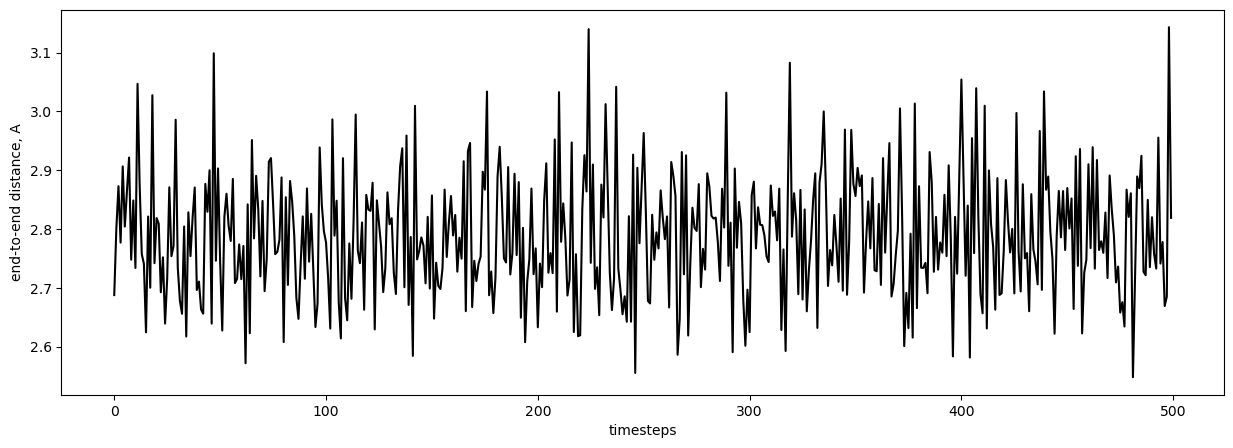

In [11]:
N_terminus = u.select_atoms('resid 1 and name O1')
C_terminus = u.select_atoms('resid 1 and name O2')

# go through the whole trajectory and compute distance between them for every frame
dist = []
for frame in u.trajectory:
    dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))

# the result is in the dist array
dist = np.array(dist)
plt.figure(figsize=(15,5))

plt.plot(dist, '-k' )
plt.xlabel('timesteps')
plt.ylabel('end-to-end distance, A')

plt.show()